In [62]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
from pysurvival.utils.display import correlation_matrix
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/akondas/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Dataset

In [2]:
raw_dataset = Dataset('churn').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head()

The raw_dataset has the following shape: (2000, 14).


,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned
0,2048,Free-Trial,Active,No,9,4,0,14,1,8.3,10-50,West North Central,3.0,1.0
1,2048,Free-Trial,Free-Trial,Active,9,4,2,12,1,0.0,100-250,South Atlantic,2.0,1.0
2,2048,Active,Active,Active,9,3,2,17,1,0.0,100-250,East South Central,7.0,0.0
3,500,Active,Free-Trial,No,10,0,0,14,0,0.0,50-100,East South Central,8.0,1.0
4,5120,Free-Trial,Active,Free-Trial,8,5,0,17,0,0.0,50-100,East North Central,7.0,0.0


# EDA

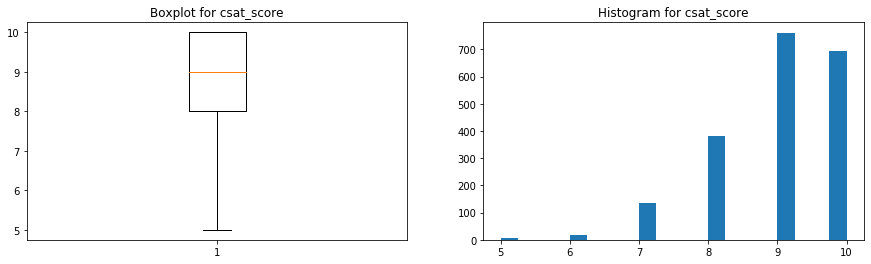

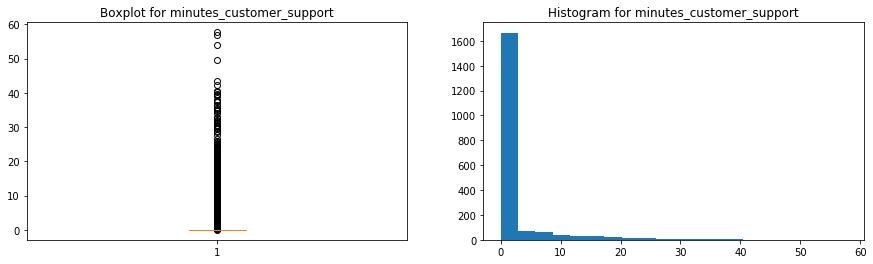

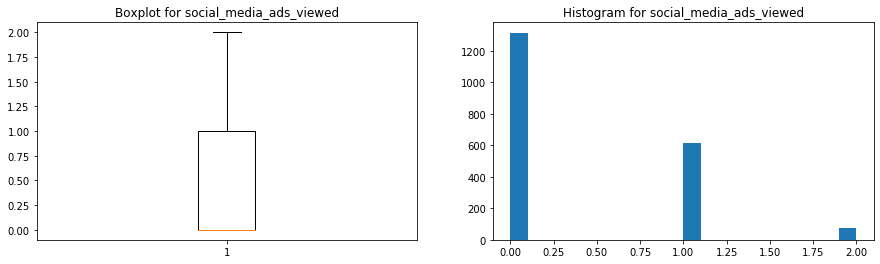

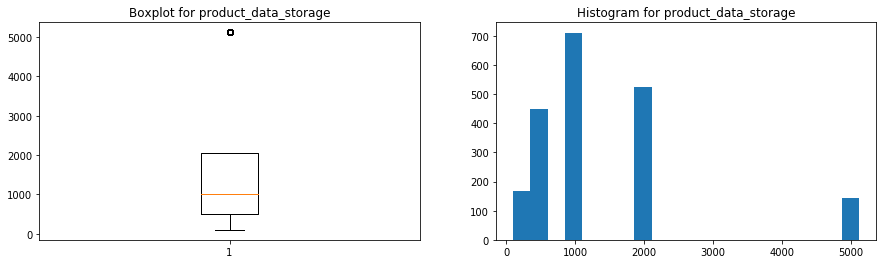

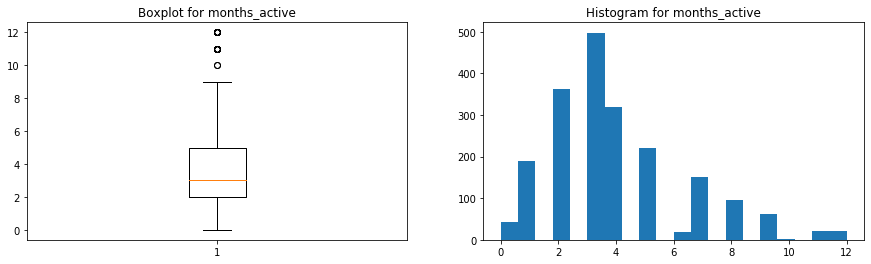

In [68]:
for feature in ['csat_score','minutes_customer_support','social_media_ads_viewed', 'product_data_storage', 'months_active']:

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(feature) )

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(feature) )

    # Display
    plt.show()

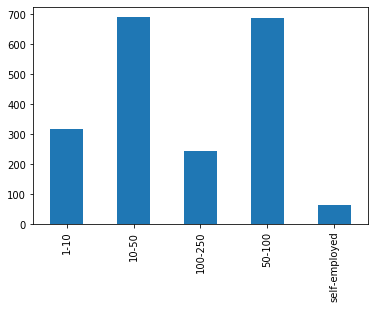

In [4]:
raw_dataset['company_size'].value_counts().sort_index().plot.bar()

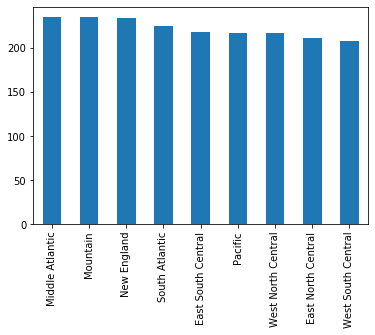

In [5]:
raw_dataset['us_region'].value_counts().plot.bar()

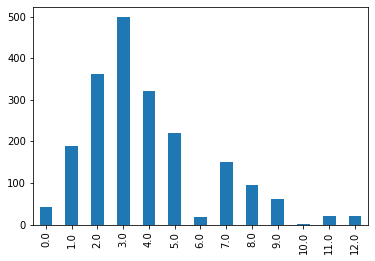

In [6]:
raw_dataset['months_active'].value_counts().sort_index().plot.bar()

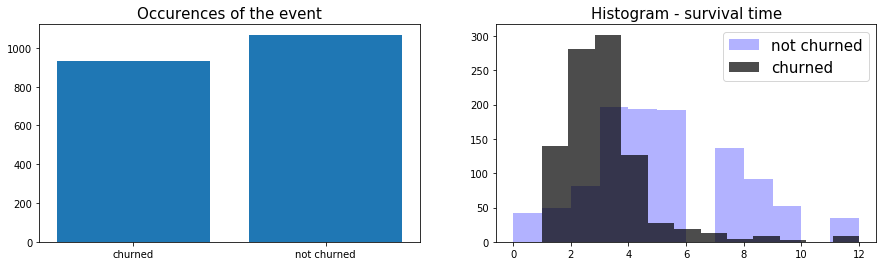

In [64]:
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

data = Counter(raw_dataset['churned'].replace({0:'not churned', 1:'churned'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title( 'Occurences of the event', fontsize=15)

time_0 = raw_dataset.loc[ raw_dataset['churned'] == 0, 'months_active']
ax2.hist(time_0, bins=12, alpha=0.3, color='blue', label = 'not churned')

time_1 = raw_dataset.loc[ raw_dataset['churned'] == 1, 'months_active']
ax2.hist(time_1, bins=12, alpha=0.7, color='black', label = 'churned')
ax2.set_title( 'Histogram - survival time', fontsize=15)

plt.legend(fontsize=15)
plt.show()

# Features extraction

In [7]:
# Creating one-hot vectors
categories = ['product_travel_expense', 'product_payroll', 'product_accounting',
              'us_region', 'company_size']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)

# Creating the time and event columns
time_column = 'months_active'
event_column = 'churned'

# Extracting the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

dataset.head()

,product_data_storage,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,months_active,churned,product_travel_expense_Free-Trial,...,us_region_Mountain,us_region_New England,us_region_Pacific,us_region_South Atlantic,us_region_West North Central,us_region_West South Central,company_size_10-50,company_size_100-250,company_size_50-100,company_size_self-employed
0,2048,9,4,0,14,1,8.3,3.0,1.0,1,...,0,0,0,0,1,0,1,0,0,0
1,2048,9,4,2,12,1,0.0,2.0,1.0,1,...,0,0,0,1,0,0,0,1,0,0
2,2048,9,3,2,17,1,0.0,7.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
3,500,10,0,0,14,0,0.0,8.0,1.0,0,...,0,0,0,0,0,0,0,0,1,0
4,5120,8,5,0,17,0,0.0,7.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0


In [8]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


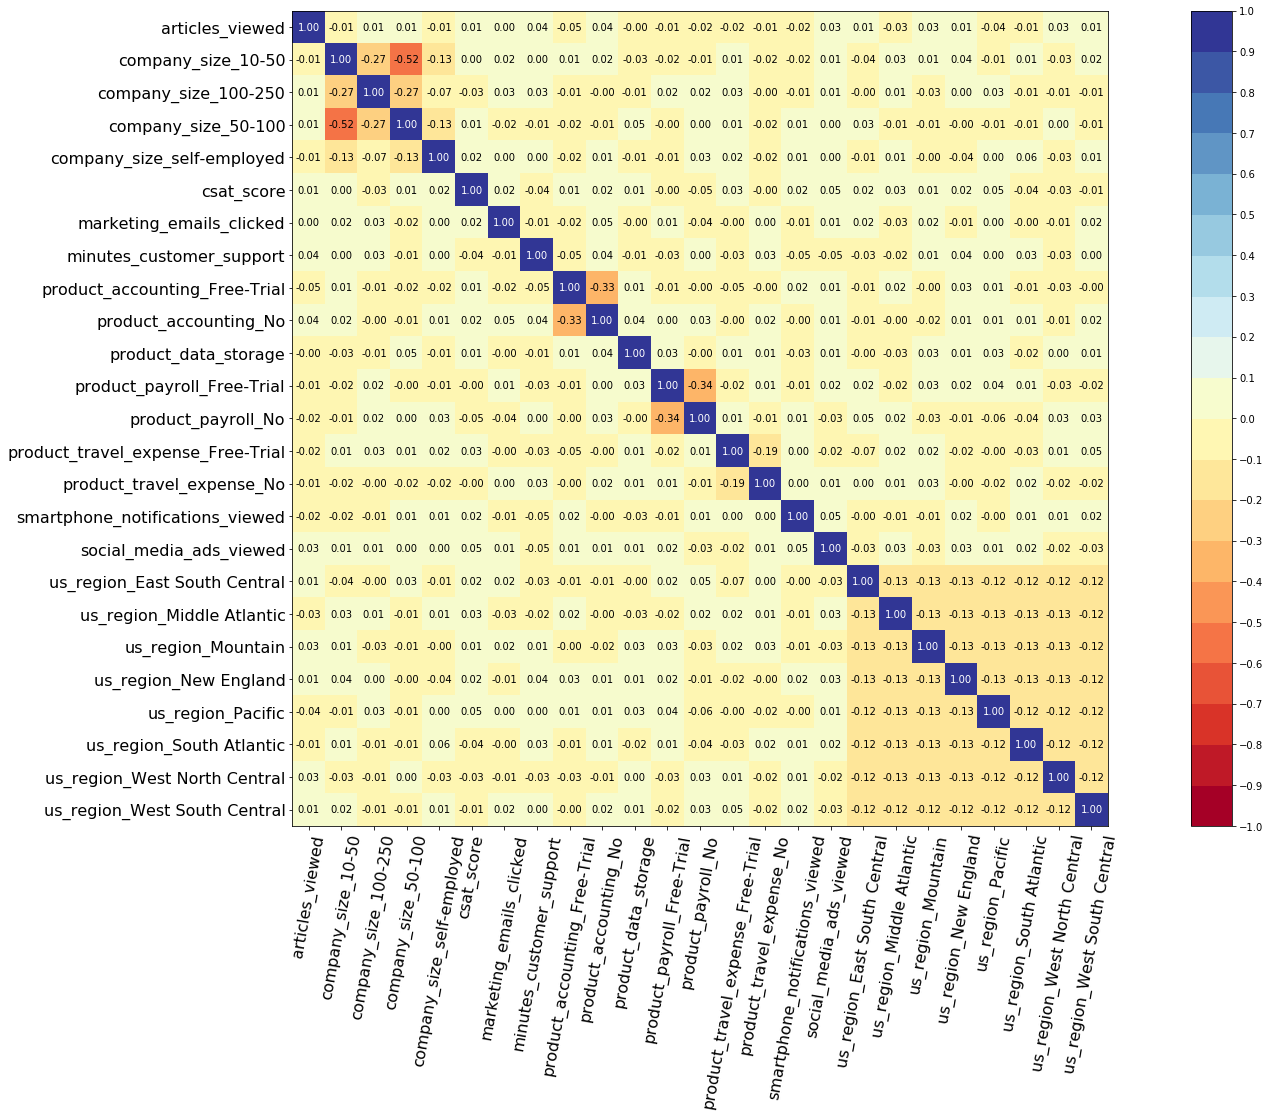

In [9]:
correlation_matrix(dataset[features], figure_size=(30,15), text_fontsize=10)

In [10]:
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.35)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

# Model


In [11]:
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1)

ConditionalSurvivalForestModel

In [12]:
csf.variable_importance_table.head(10)

,feature,importance,pct_importance
0,csat_score,14.864785,0.236844
1,product_payroll_No,11.386541,0.181424
2,product_accounting_No,8.632472,0.137543
3,minutes_customer_support,8.245457,0.131377
4,product_payroll_Free-Trial,4.542412,0.072375
5,product_travel_expense_Free-Trial,4.440812,0.070756
6,smartphone_notifications_viewed,3.921595,0.062484
7,product_data_storage,1.908522,0.030409
8,social_media_ads_viewed,1.430461,0.022792
9,us_region_New England,1.198627,0.019098


# Deep model

In [13]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel

dcsf = NonLinearCoxPHModel(structure=[ {'activation': 'BentIdentity', 'num_units': 200}])
dcsf.fit(X_train, T_train, E_train, lr=1e-3, init_method='xav_uniform', num_epochs = 1000)

% Completion: 100%|**********************************************|Loss: 3357.54


NonLinearCoxPHModel( Layer(1): activation = BentIdentity, num_units = 200 )

C-index: 0.88


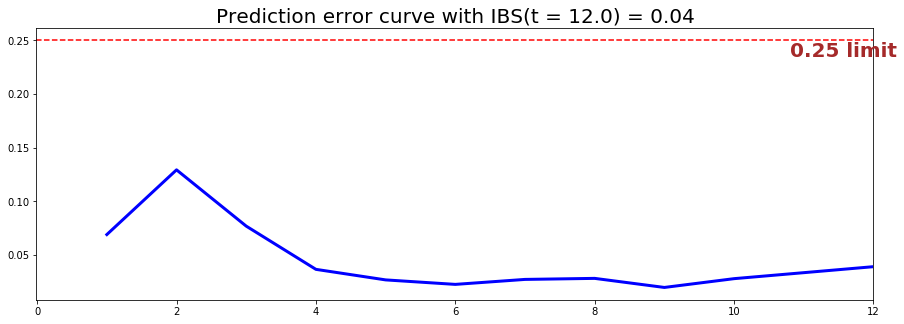

IBS: 0.04


In [14]:
c_index = concordance_index(dcsf, X_test, T_test, E_test) #0.81
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(dcsf, X_test, T_test, E_test, t_max=12, figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

# LMTM Model

% Completion: 100%|**********************************************|Loss: 2317.28


C-index: 0.89


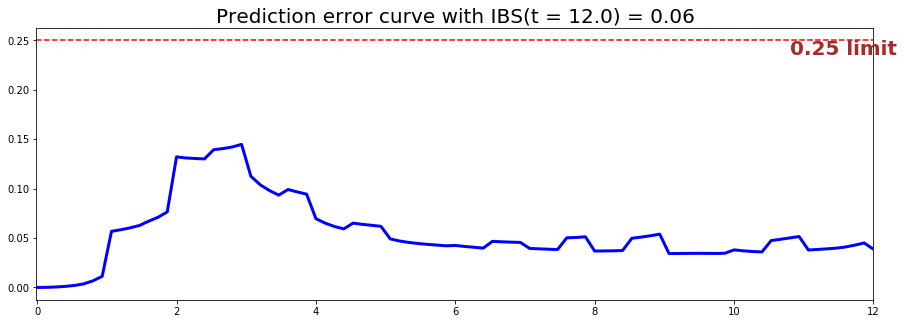

IBS: 0.06


In [15]:
from pysurvival.models.multi_task import LinearMultiTaskModel

lmtm_csf = LinearMultiTaskModel(bins=100)
lmtm_csf.fit(X_train, T_train, E_train, lr=1e-4, init_method='orthogonal', num_epochs=1000)

c_index = concordance_index(lmtm_csf, X_test, T_test, E_test) #0.81
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(lmtm_csf, X_test, T_test, E_test, t_max=12, figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

# Validation

In [16]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.85


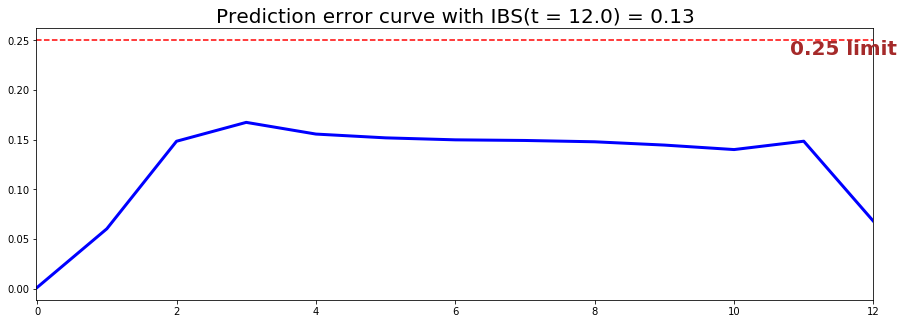

IBS: 0.13


In [17]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=12,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

# Prediction

In [18]:
X_test.shape

(700, 25)

## Conditional

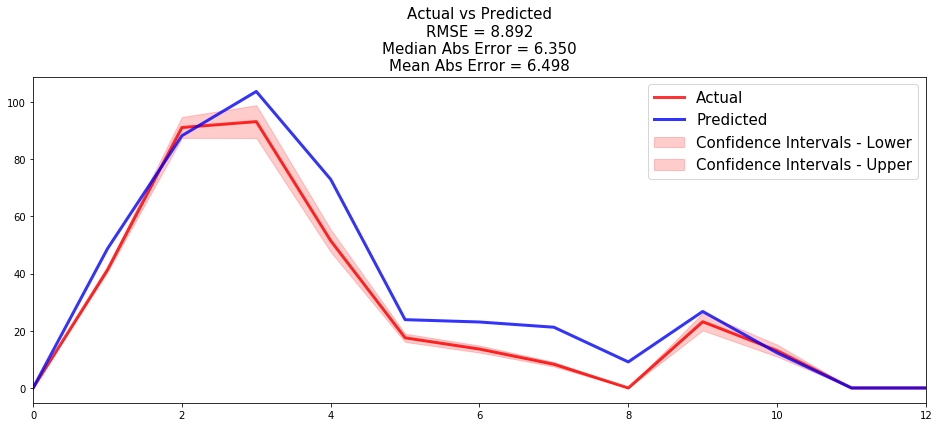

In [19]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

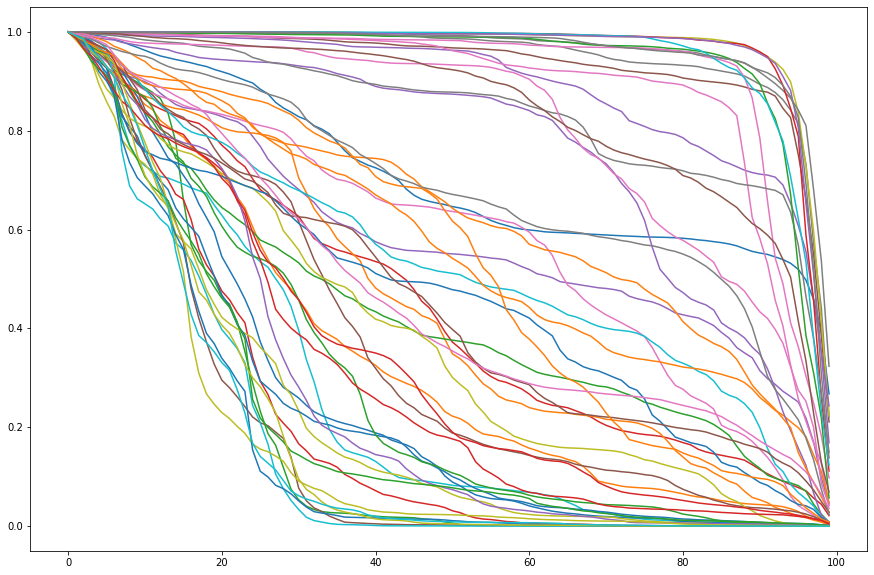

In [60]:
X_test.iloc[0]
E_test.iloc[0]
T_test.iloc[0]

plt.figure(figsize=(15,10))
for x in range(50):
    plt.plot(range(100), lmtm_csf.predict_survival(X_test.iloc[x])[0])

## Deep

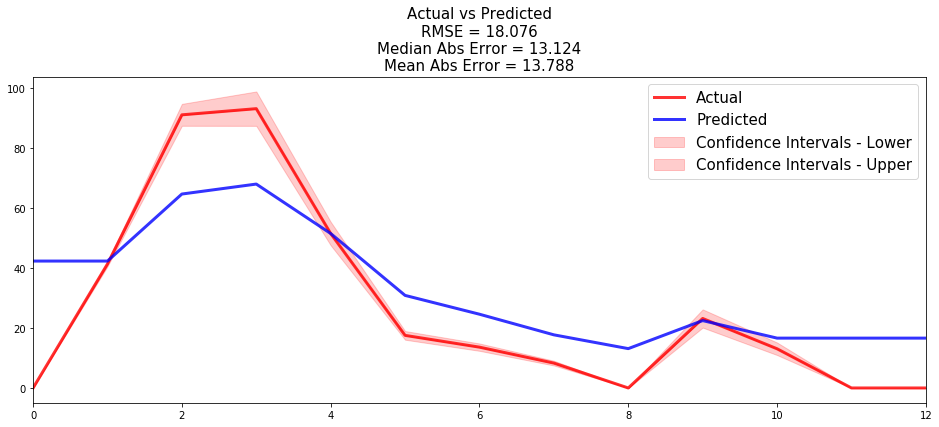

In [24]:
results = compare_to_actual(dcsf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

## LMTM

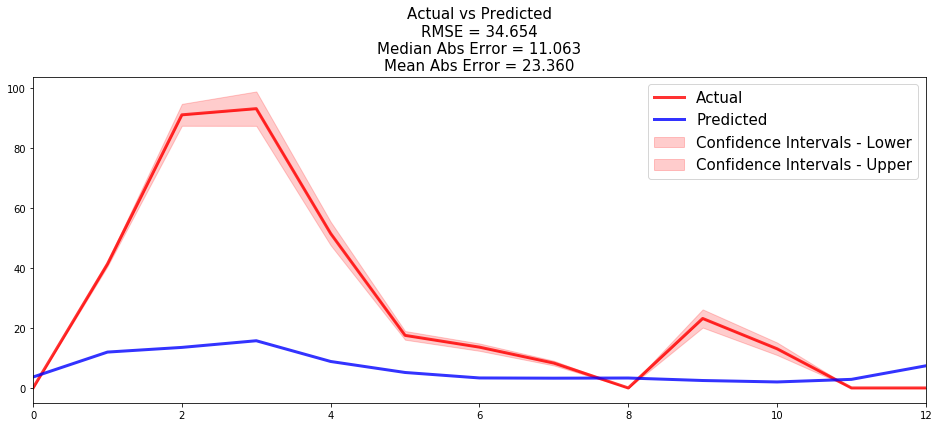

In [20]:
results = compare_to_actual(lmtm_csf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

# Risk group

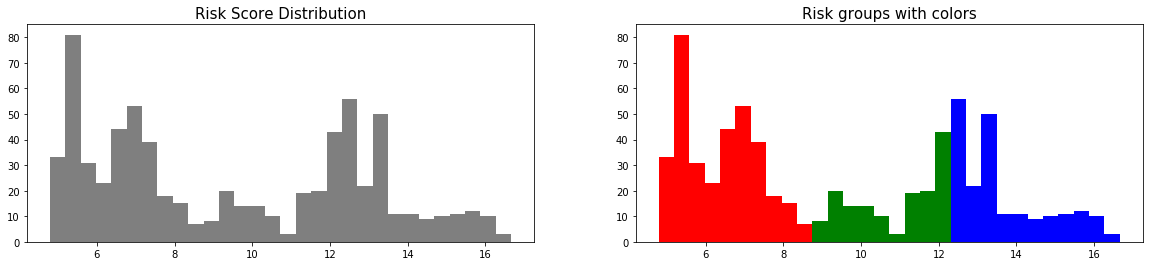

In [21]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=csf, X=X_test,
    use_log = False, num_bins=30, figure_size=(20, 4),
    low={'lower_bound':0, 'upper_bound':8.5, 'color':'red'},
    medium={'lower_bound':8.5, 'upper_bound':12.,'color':'green'},
    high={'lower_bound':12., 'upper_bound':25,  'color':'blue'}
    )

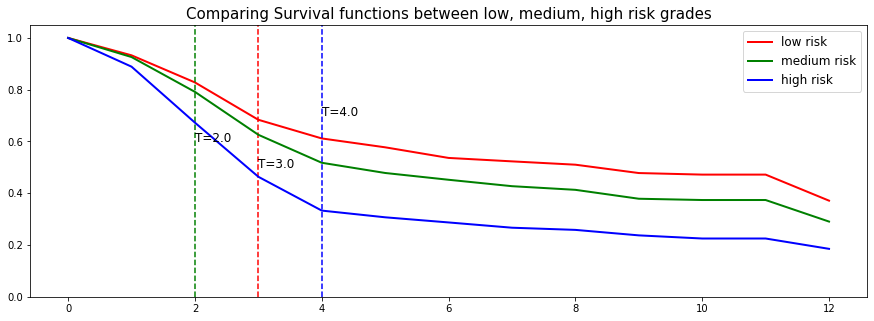

In [22]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = csf.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(csf.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()